# Landsat Land Surface Temperature <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


* **Products used:** 
[usgs_ls8c_level2_2](https://explorer.digitalearth.africa/ga_ls8c_gm_2_annual)
* **Special requirements:** Surface Temperture is available as part of the USGS Landsat Collection 2 Level-2 product.
* **Prerequisites:** For more information about the Landsat Collection 2 datasets, refer to the [Landsat collections notebook](../Datasets/Landsat_collections.ipynb)


## Background

Surface Temperature measures the Earth’s surface temperature (units Kelvin) and is an important geophysical parameter in global energy balance studies and hydrologic modeling. Surface temperature is also useful for monitoring crop and vegetation health, and extreme heat events such as natural disasters (e.g., volcanic eruptions, wildfires), and urban heat island effects. 

The surface temperature product is generated from the Landsat Collection 2 Level-1 thermal infrared bands, Top of Atmosphere (TOA) reflectance, TOA brightness temperature, Advanced Spaceborne Thermal Emission and Reflection Radiometer (ASTER) Global Emissivity Database (GED) data, ASTER Normalized Difference Vegetation Index (NDVI) data, and atmospheric profiles of geopotential height, specific humidity, and air temperature extracted from Goddard Earth Observing System (GEOS) Model , Version 5, Forward Processing Instrument Teams (FP-IT) (for acquisitions from 2000 to present) or Modern Era Retrospective analysis for Research and Applications Version 2 (MERRA-2) (for acquisitions from 1982 to 1999).

For more information and caveats of the product, visit the [Landsat Science Products Overview](https://www.usgs.gov/land-resources/nli/landsat/landsat-collection-2-level-2-science-products) and the [Landsat Surface Temperature webpage](https://www.usgs.gov/land-resources/nli/landsat/landsat-surface-temperature).

The surface temperature product is provided at 30 m spatial sampling, however, the thermal sensors vary in spectral response, sensitivity and resolution.

Satellite | Sensor | Spetral Band | Wavelength (µm) | Spatial Resolution (m) |
:-------: | :-------: | :-------: | :-------: | :-------: |
Landsat 8 | Thermal Infrared Sensor (TIRS) | 10 | 10.60 - 11.19 | 100 
  |  | 11 | 11.50 - 12.51 | 100 
Landsat 7 | Enhanced Thematic Mapper Plus (ETM+) | 6 | 10.31 - 12.36 | 60
Landsat 5 | Thematic Mapper (TM) | 6 | 10.40 - 12.50 | 120


Relevant Measurements

Name | Explanation |
:------- | :------- 
surface_temperature | The temperature of the Earth’s surface in Kelvin (K); to use, scale by 0.00341802 + 149.0
thermal_radiance | The values produced when thermal band reflectance is converted to radiance.
upwell_radiance | The amount of electromagnetic radiation reflected upward from the ground’s surface.
downwell_radiance | The thermal energy radiated onto the ground by all objects in a hemisphere surrounding it.
atmospheric_transmittance | The ratio of the transmitted radiation to the total radiation incident upon the medium (atmosphere).
emissivity | The ratio of the energy radiated from a material’s surface to that radiated from a blackbody.
emissivity_stdev | The extent of deviation of the emissivity product. This layer is used along with cloud_distance to create the quality assessment product. 
cloud_distance | The distance, in kilometers, that a pixel is from the nearest cloud pixel. This layer is used along with emissivity_stdev to create the quality assessment product.
quality_l2_surface_temperature | Provides the Surface Temperature product uncertainty using a combination of uncertainty values and distance to cloud values.


## Description

This notebook demonstrates how to load and use the land surface temperature product as part of the Landsat Collection 2 dataset. Topics covered include:

1. Load surface temperature and filter with quality assessment
2. Compare mean surface temperature to daily air temperature at 2-meters height from ERA5
3. Inspect related land surface characteristics

***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr

sys.path.append("../Scripts")
from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_load_era5 import load_era5

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='land_surface_temperature')

### Analysis parameters


In [3]:
# Define the analysis region (Lat-Lon box)

# Il Ngwesi region of Kenya - Rhino Project
lat = (0.412, 0.266)
lon = (37.32, 37.40)

# High Energy Stereoscopic System site near Windhoek Namibia
lat = (-23.275, -23.265)
lon = (16.495, 16.505)

# Define the time window
time = '2018-07-01', '2019-05-31'

query = {'lat': lat, 'lon':lon, 'time':time}

## Load surface temperature and filter with quality assessment


In [4]:
# Display available measurements
dc.list_measurements().loc['usgs_ls8c_level2_2']

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
coastal_aerosol,coastal_aerosol,uint16,1,0,"[b1, band_1]",NaN
blue,blue,uint16,1,0,"[b2, band_2]",NaN
green,green,uint16,1,0,"[b3, band_3]",NaN
red,red,uint16,1,0,"[b4, band_4]",NaN
nir,nir,uint16,1,0,"[b5, band_5]",NaN
swir_1,swir_1,uint16,1,0,"[b6, band_6, swir1]",NaN
swir_2,swir_2,uint16,1,0,"[b7, band_7, swir2]",NaN
surface_temperature,surface_temperature,uint16,Kelvin,0,"[b10, band_10, st_b10]",NaN
thermal_radiance,thermal_radiance,int16,1,-9999,[st_trad],NaN


In [5]:
# Load land surface temperature and quality assessment
measurements = ['surface_temperature', 'quality_l2_surface_temperature']

In [6]:
# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='usgs_ls8c_level2_2', query=query)

data = dc.load(product='usgs_ls8c_level2_2', **query, 
               measurements = measurements,
               output_crs = output_crs, resolution = (-30, 30))

In [7]:
# make nodata nan
for band in list(data.data_vars):
    # emissivity_stdev band is not filled with nodata as other bands
    if band == 'emissivity_stdev': band2 = 'emissivity'
    else: band2 = band
    data[band] = data[band].where(data[band2] != data[band2].attrs['nodata']).where(data[band2].notnull())

In [8]:
# drop empty slices
data = data.dropna(dim='time', how='all')

In [9]:
# convert to Kelvin using scaling factor and then to Celcius
data['surface_temperature'] = data.surface_temperature*0.00341802 + 149.0 - 273.15

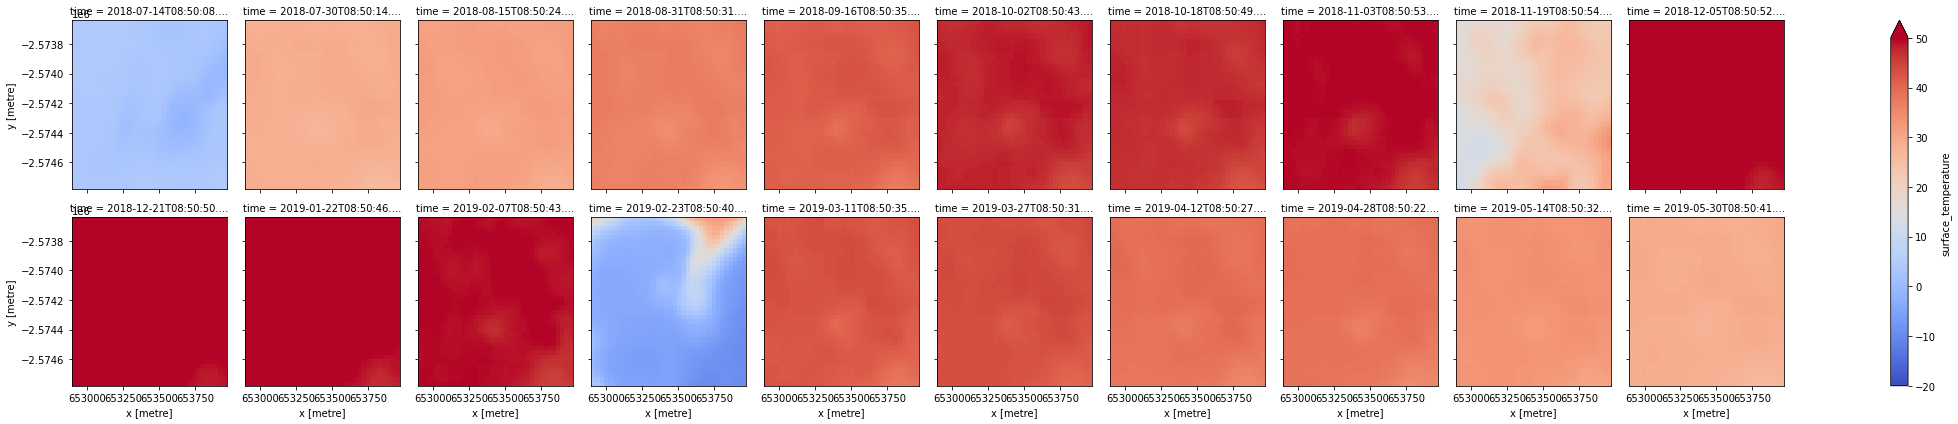

In [10]:
# plot surface temperature over time
data.surface_temperature.plot.imshow(col='time', col_wrap=10, vmin=-20, vmax=50, cmap='coolwarm');

In [11]:
# a threshold of 400 is found to be reasonable in filtering out unreliable surface temperature estimate
thresh = 400

# alternatively, a threshold can be determined by examining the quality assessment value distribution
# e.g. 

#from skimage import filters
#thresh = filters.threshold_otsu(data.quality_l2_surface_temperature.values)
#data.quality_l2_surface_temperature.plot.hist(bins = np.arange(200, 800,20));
#plt.axvline(thresh)

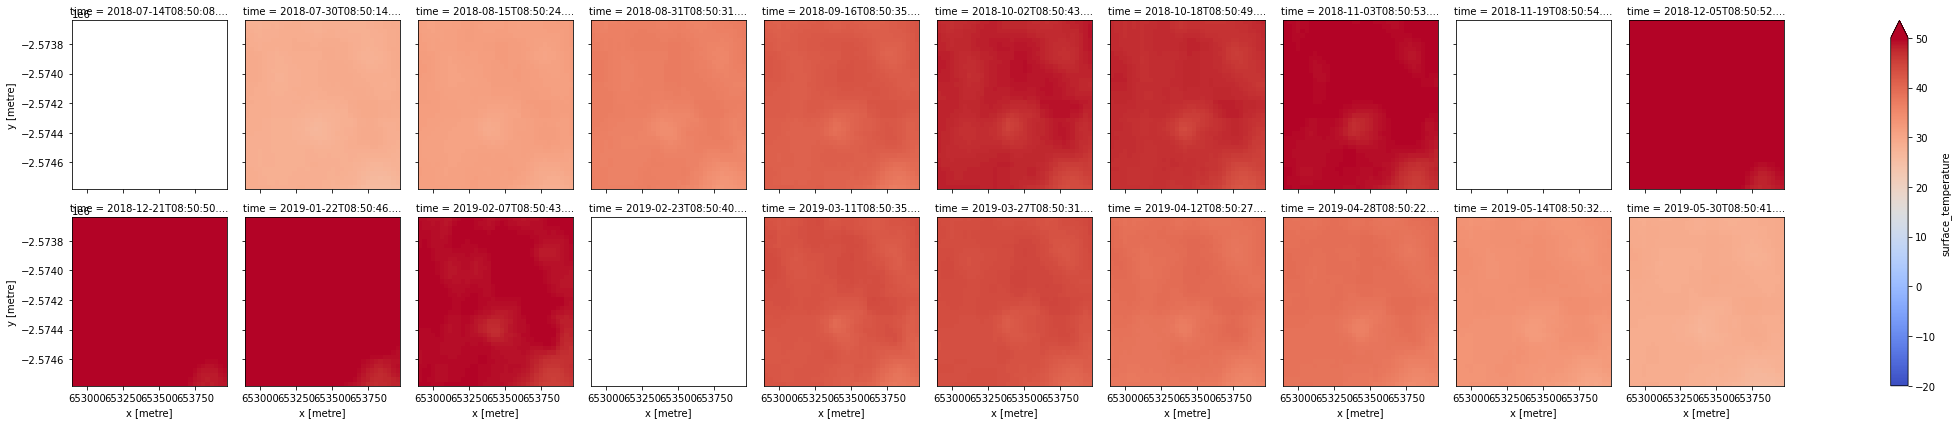

In [12]:
# plot filtered surface temperature over time
data.surface_temperature.where(data.quality_l2_surface_temperature<=thresh).plot.imshow(col='time', col_wrap=10, vmin=-20, vmax=50, cmap='coolwarm');

##  Compare mean surface temperature to daily air temperature at 2-meters height from ERA5


In [13]:
# Load ERA5 air temperature at 2 m height
var = 'air_temperature_at_2_metres'

air_temp = load_era5(var, lat, lon, time, reduce_func=np.mean)[var] - 273.15

In [14]:
# Apply quality filtering
good_lst = data.surface_temperature.where(data.quality_l2_surface_temperature<=thresh)

# Exclude scenes in which less than half of all pixels are good
valid = good_lst.notnull().groupby('time').mean(dim=xr.ALL_DIMS) > 0.5

# Calculate mean surface temperature for the area
good_lst = good_lst.isel(time=valid).groupby('time').mean(dim=xr.ALL_DIMS)

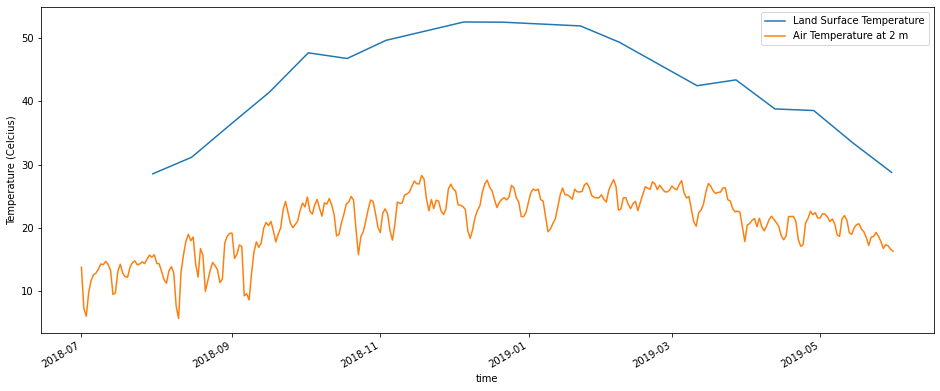

In [15]:
# Plot mean surface tempeature and air temperature at 2 m

good_lst.plot(figsize = (16, 6),label='Land Surface Temperature');
air_temp.groupby('time').mean(dim=xr.ALL_DIMS).plot(label='Air Temperature at 2 m');
plt.ylabel('Temperature (Celcius)')
plt.legend();

## Inspect related land surface characteristics


In [16]:
bands = ["swir1", "nir", "red", "green"]

ds = dc.load(product='usgs_ls8c_level2_2',
             measurements=bands,
             output_crs=output_crs,
             resolution = (-30, 30),
             dask_chunks={},
             **query)

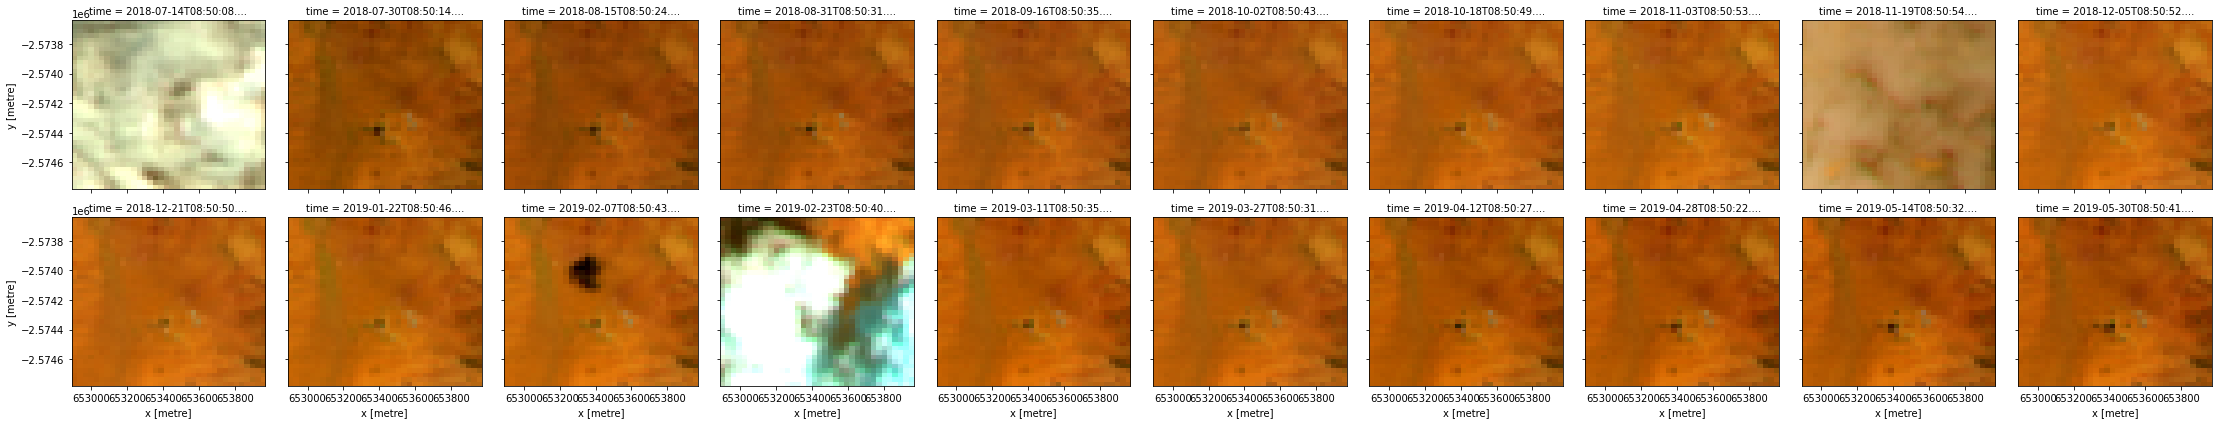

In [17]:
# insepct in false color; filtering by quality assessment above should have exluded areas/scenes covered by cloud
ds[["swir1", "nir", "green"]].to_array().plot.imshow(robust=True, col='time', col_wrap=10);

In [18]:
# calculate NDVI

ds['ndvi'] = (ds.nir - ds.red) / (ds.nir + ds.red)

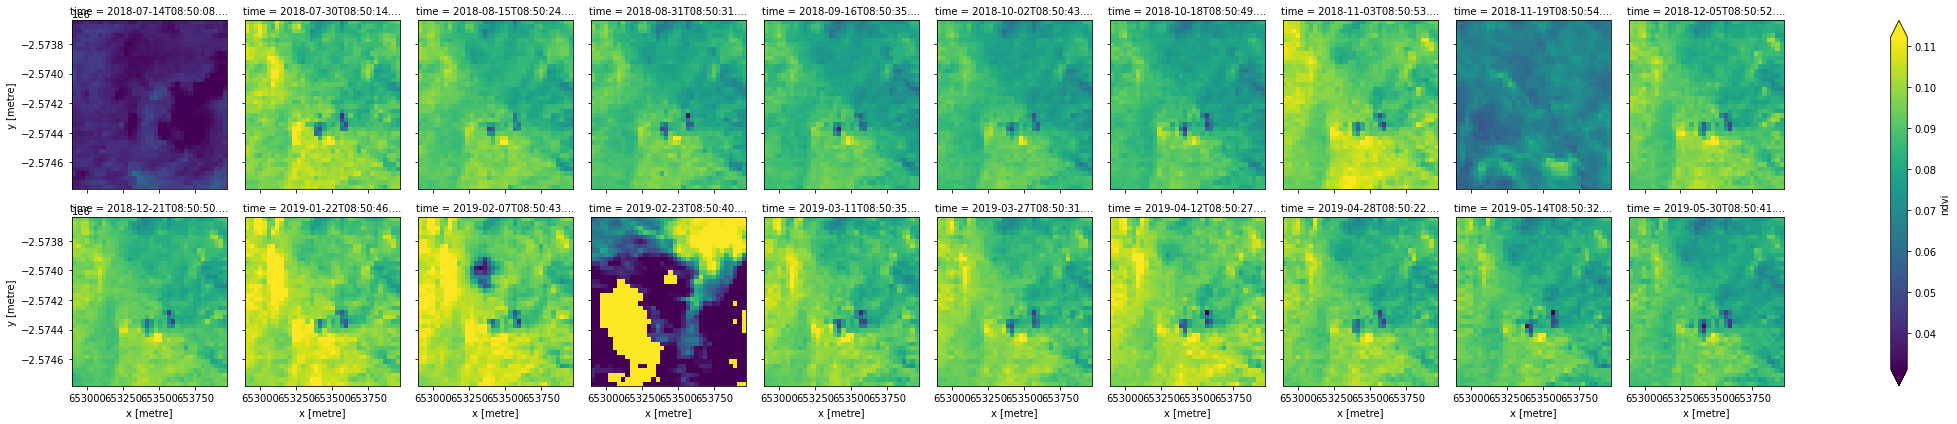

In [19]:
# visualise NDVI
# a value lower than ~0.1 means low to no vegetation cover
# a value higher than ~0.5 suggests dense vegetation cover
ds.ndvi.plot.imshow(robust=True, col='time', col_wrap=10);

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [20]:
print(datacube.__version__)

1.7+262.g1cf3cea8


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)